<a href="https://colab.research.google.com/github/zhaw-iwi/FishNET/blob/main/ML_Modell_MobilenetV2_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import der einzelnen Bibliotheken

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
import zipfile
from keras import layers
#from keras import datasets, layers, models
#$ pip install pyyaml h5py


In [32]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
 #local_zip = "/content/gdrive/MyDrive/Daten_Images/images_categorized_8.zip"

In [ ]:

#zip_ref = zipfile.ZipFile(local_zip, 'r')
#zip_ref.extractall('/content/gdrive/MyDrive/Test')
#zip_ref.close()


In [33]:
local_file = '/content/gdrive/MyDrive/Test'

In [34]:
PATH = os.path.join(os.path.dirname(local_file), 'Test')

In [35]:
raw_dataset = os.path.join(PATH, 'images_categorized_8')

In [36]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

In [37]:
all_dataset = tf.keras.utils.image_dataset_from_directory(raw_dataset,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE,
                                                            )

Found 1985 files belonging to 21 classes.


In [ ]:
print(all_dataset)

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [ ]:
# class_names = all_dataset.class_names

# plt.figure(figsize=(10, 10))
# for images, labels in all_dataset.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

In [38]:
val_batches_1 = tf.data.experimental.cardinality(all_dataset)
validation_dataset = all_dataset.take(val_batches_1 // 5)
train_dataset = all_dataset.skip(val_batches_1 // 5)

In [ ]:
#print(val_batches_1)

tf.Tensor(56, shape=(), dtype=int64)


In [ ]:
#print('Number of train batches: %d' % tf.data.experimental.cardinality(train_dataset))
#print('Number of test batches: %d' % tf.data.experimental.cardinality(validation_dataset))

Number of train batches: 45
Number of test batches: 11


In [39]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

Use data augmentation

In [ ]:

# data_augmentation = tf.keras.Sequential(
#     [
#   layers.RandomFlip('horizontal'),
#   layers.RandomRotation(0.2),
#   layers.RandomZoom(0.1),
#   layers.RandomHeight(0.3),
#   layers.RandomWidth(0.3)
#   ]
#   )

In [ ]:
#  input_shape_rgb = (224, 224, 3)
#  data_augmentation_rgb = tf.keras.Sequential(
#    [ 
#      layers.RandomFlip("horizontal"),
#      layers.RandomFlip("vertical"),
#      layers.RandomRotation(0.5),
#     layers.RandomZoom(0.5),
#      layers.RandomContrast(0.5),
#    ]
#  )

In [ ]:
# with tf.device('/cpu:0'): data_augmentation_1 = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

In [ ]:
#data_augmentation = data_augmentation_1(train_dataset,training=True)

In [ ]:
# data_augmentation_2 = tf.keras.Sequential(
#     [
#   layers.RandomZoom(0.1),
#   layers.RandomHeight(0.3),
#   ]
#   )

In [ ]:
# data_augmentation_3 = tf.keras.Sequential(
#     [
#   layers.RandomWidth(0.3)
#   ]
#   )

In [ ]:
 #print(data_augmentation_1)

Custom Data Augmentation

In [ ]:
# for image, _ in train_dataset.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation_1(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

Rescale Pixel Values

In [57]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [58]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

Create the base model from the pre-trained convnets

In [59]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [60]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 7, 7, 1280)


Feature extraction

Freeze the convolutional base

In [ ]:
# Fine-tune from this layer onwards
#fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
#for layer in base_model.layers[:fine_tune_at]:
 # layer.trainable = False



In [61]:
base_model.trainable = False

Important note about BatchNormalization layers

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Add a classification head

In [62]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [63]:
prediction_layer = tf.keras.layers.Dense(21)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 21)


In [82]:
inputs = tf.keras.Input(shape=(224, 224, 3))
#x = data_augmentation_rgb(inputs)
#x = data_augmentation_1(inputs)
#x = data_augmentation_2(x)
#x = data_augmentation_3(x)
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.Conv2D(1280, (2, 2), activation='relu')(x)
x = layers.MaxPooling2D((2, 2))(x)
#x = layers.Conv2D(1280, (2, 2), activation='relu')(x)
#x = layers.MaxPooling2D((2, 2))(x)


x = global_average_layer(x)
x = layers.Flatten()(x)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(1280)(x)
#x = tf.keras.layers.Dropout(0.2)(x)
#x = tf.keras.layers.Dense(1280)(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1280)(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)



Compile the model

In [83]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(),#learning_rate=base_learning_rate
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

In [84]:
len(model.trainable_variables)

6

Train the model

In [85]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

6/6 [==============================] - 11s 773ms/step - loss: 4.0802 - accuracy: 0.0599


In [86]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 4.08
initial accuracy: 0.06


In [87]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    )

Epoch 1/10
26/26 [==============================] - 35s 888ms/step - loss: 7.1525 - accuracy: 0.2280 - val_loss: 1.9736 - val_accuracy: 0.4010
Epoch 2/10
26/26 [==============================] - 32s 863ms/step - loss: 1.6993 - accuracy: 0.4453 - val_loss: 1.2625 - val_accuracy: 0.5651
Epoch 3/10
26/26 [==============================] - 31s 854ms/step - loss: 1.1866 - accuracy: 0.6090 - val_loss: 1.0159 - val_accuracy: 0.6901
Epoch 4/10
26/26 [==============================] - 33s 913ms/step - loss: 0.9309 - accuracy: 0.6858 - val_loss: 0.6895 - val_accuracy: 0.7734
Epoch 5/10
26/26 [==============================] - 32s 870ms/step - loss: 0.6656 - accuracy: 0.7814 - val_loss: 0.6524 - val_accuracy: 0.7786
Epoch 6/10
26/26 [==============================] - 31s 856ms/step - loss: 0.5397 - accuracy: 0.8276 - val_loss: 0.4716 - val_accuracy: 0.8438
Epoch 7/10
26/26 [==============================] - 31s 852ms/step - loss: 0.3897 - accuracy: 0.8801 - val_loss: 0.3645 - val_accuracy: 0.8958

In [90]:
!mkdir -p saved_model
model.save('/content/gdrive/MyDrive/Test/trained_model.h5')

In [ ]:
# checkpoint_path = "/content/gdrive/MyDrive/Test/trained_weights.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# # Create a callback that saves the model's weights
# cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                  save_weights_only=True,
#                                                  verbose=1)

# history = model.fit(train_dataset,
#                     epochs=initial_epochs,
#                     validation_data=validation_dataset,
#                     callbacks=[cp_callback]) # Pass callback to training)

                         

In [88]:
loss, acc = model.evaluate(validation_dataset, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

6/6 - 10s - loss: 0.1332 - accuracy: 0.9635 - 10s/epoch - 2s/step
Restored model, accuracy: 96.35%


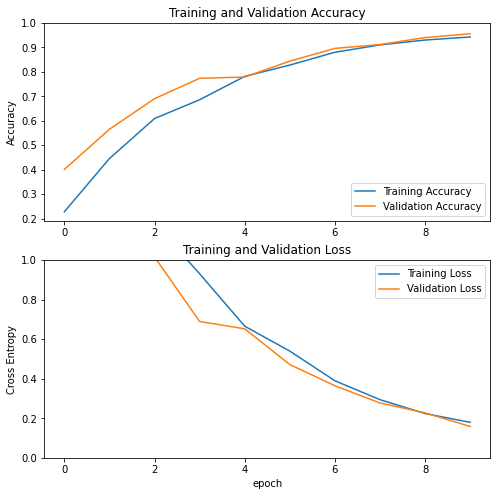

In [89]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Predictions:
 [1 0 1 ... 1 0 1]
Labels:
 [ 2 15  7  7  9 16  6  6 14  0  3  1 10 10 19 15  0  6 18 17 17 17  6  9
  6  5 19 11  7  6  9 17  8 10  4 10  9  9  7 15  7  4  8 16  0 19  1 13
  0  2 11  2  6  9  8 13 16 17 13 10  8  2 17  8]


NameError: ignored

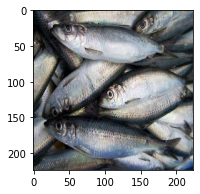

In [ ]:
# Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

Testing load saved Model from Google Drive

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('/content/gdrive/MyDrive/Test/trained_model.h5')

# Show the model architecture
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                             

In [ ]:
loss, acc = new_model.evaluate(validation_dataset, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

11/11 - 7s - loss: 0.8722 - accuracy: 0.7216 - 7s/epoch - 665ms/step
Restored model, accuracy: 72.16%


In [ ]:
# new_model.redict() --> was ist das?